In [18]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [86]:
def rolling_mean(a, n) :
    res = []
    for i in range(len(a)) :
        i_min = max(0, i-n)
        i_max = min(len(a), i+n+1)
        res.append(np.nanmean(a[i_min:i_max], axis = 0))
    return res

class FaceExtractor :
    def __init__(self) :
        """Value based on celeba dataset"""
        self.face_cascade = cv2.CascadeClassifier('/usr/local/opencv-4.1.1/share/opencv4/haarcascades/haarcascade_frontalface_default.xml')
        self.x_target = 36.3877551
        self.w_target = 104.44897959
        self.y_target = 72.02040816
        self.h_target = 104.44897959
        self.w = 178
        self.h = 218

    def extract(self, path, rolling_avg_nb = 2, verbose=False) :
        vidcap = cv2.VideoCapture(path)
        images = []
        success,image = vidcap.read()
        count = 0
        while success:
            images.append(image)
            success,image = vidcap.read()
            count += 1

        face_potential_positions = []        
        for image in images :
            h,w,_ = image.shape
            faces = self.face_cascade.detectMultiScale(image)
            current = []
            for (fx,fy,fw,fh) in faces:
                if fw > w/10 and fh>h/6 :
                    if verbose : 
                        cv2.rectangle(image,(fx,fy),(fx+fw,fy+fh),(0,255,0),2)
                    current.append(np.array([fx,fy,fw,fh]))
            face_potential_positions.append(current)
        
        avg_positions = [np.mean(positions, axis = 0) for positions in face_potential_positions]
        rolled_avg_positions = rolling_mean(avg_positions, rolling_avg_nb)
        
        if verbose : 
            for pos,image in zip(rolled_avg_positions, images) :
                (fx,fy,fw,fh) = [int(c) for c in pos]
                cv2.rectangle(image,(fx,fy),(fx+fw,fy+fh),(255,0,0),2)
                plt.imshow(image[:,:,::-1])
                plt.show()
        
        croped = []
        for pos,image in zip(rolled_avg_positions, images) :
            (fx,fy,fw,fh) = pos
            h,w,_ = image.shape
            x_start = fx-fw/self.w_target*self.x_target
            x_end = x_start + fw/self.w_target*self.w
            y_start = fy-fw/self.w_target*self.y_target
            y_end = y_start + fw/self.w_target*self.h
            x_start,x_end,y_start,y_end = [int(v) for v in (x_start,x_end,y_start,y_end)]
            croped.append(image[y_start:y_end,x_start:x_end])
        return croped
    
    def save_images(self, images, name) :
        for i,image in enumerate(images) :
            cv2.imwrite("frames/" + name + "_frame_{:06d}.jpg".format(i), image)
            
            

In [73]:
extractor = FaceExtractor()
result = extractor.extract('test-video.mov', verbose = False)

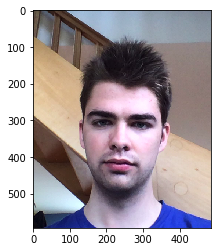

In [87]:
extractor.save_images(result, "test")
plt.imshow(result[1][:,:,::-1])